# 🚀 Face Landmark Auto-Annotate (Google Colab)
✅ ใช้ OpenCV เพื่อตรวจจับใบหน้าและสร้างจุด Landmark อัตโนมัติ
📌 นำไปใช้กับ Roboflow ได้ทันที!

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install inference-sdk --quiet
!pip install mediapipe --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 46.7 MB/s eta 0:00:00


In [2]:
from inference_sdk import InferenceHTTPClient
# 🚀 ตั้งค่า API ของ Roboflow
client = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="cnUHc0LGMmwIYKDyFMbr"
)

In [35]:
import cv2
import requests
import numpy as np
import mediapipe as mp

#ตั้งค่า API Key และ Model ID ของ Roboflow
API_KEY = "cnUHc0LGMmwIYKDyFMbr"
MODEL_ID = "face-detection-xafgu/1"
IMAGE_PATH = "/content/drive/MyDrive/AI_photobooth/music.bnk48official_277148947_159799699762362_2978065214672688666_n.jpg"

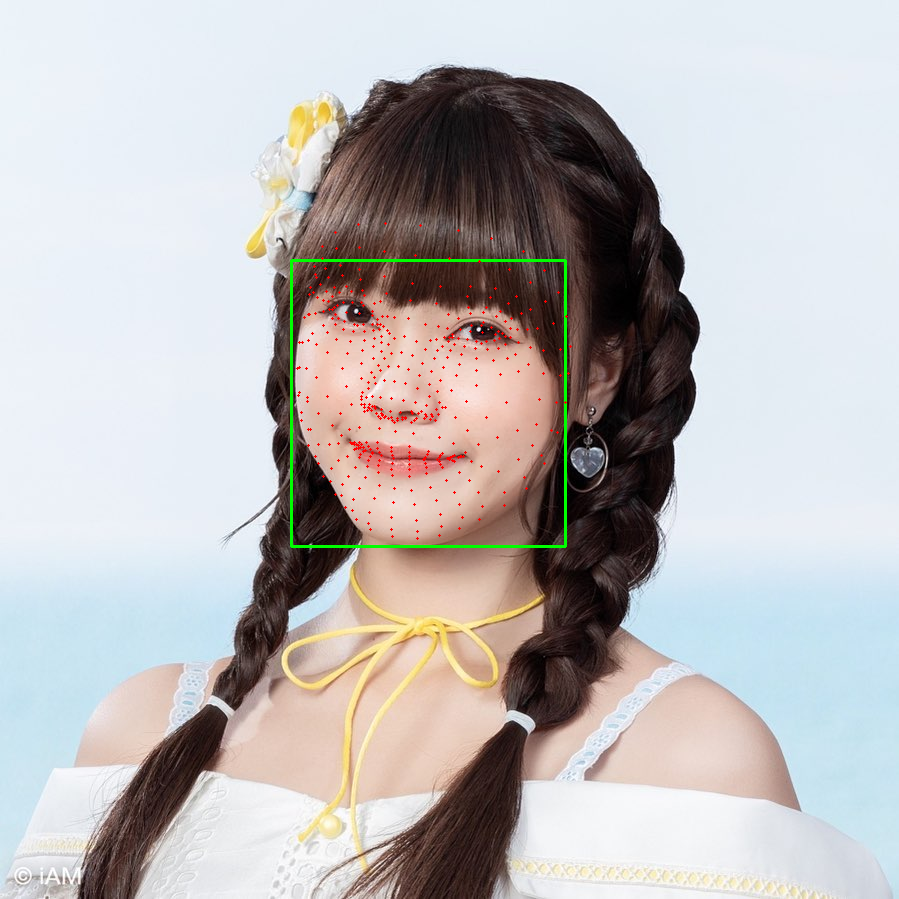

In [36]:
#ส่งภาพไปที่ Roboflow API เพื่อตรวจจับใบหน้า
url = f"https://detect.roboflow.com/{MODEL_ID}?api_key={API_KEY}"
files = {"file": open(IMAGE_PATH, "rb")}
response = requests.post(url, files=files)

image = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#ตรวจสอบ Bounding Box
if response.status_code == 200:
    result = response.json()
    for prediction in result["predictions"]:
        x, y, w, h = int(prediction["x"]), int(prediction["y"]), int(prediction["width"]), int(prediction["height"])
        x1, y1, x2, y2 = x - w // 2, y - h // 2, x + w // 2, y + h // 2
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

#ใช้ MediaPipe Face Mesh เพื่อตรวจจับ Landmark
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
results = face_mesh.process(image_rgb)

#ตรวจสอบ Landmark
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        for landmark in face_landmarks.landmark:
            lx, ly = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
            cv2.circle(image_rgb, (lx, ly), 1, (255, 0, 0), -1)

#แสดงผลภาพหลังตรวจจับใบหน้าและ Landmark
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))

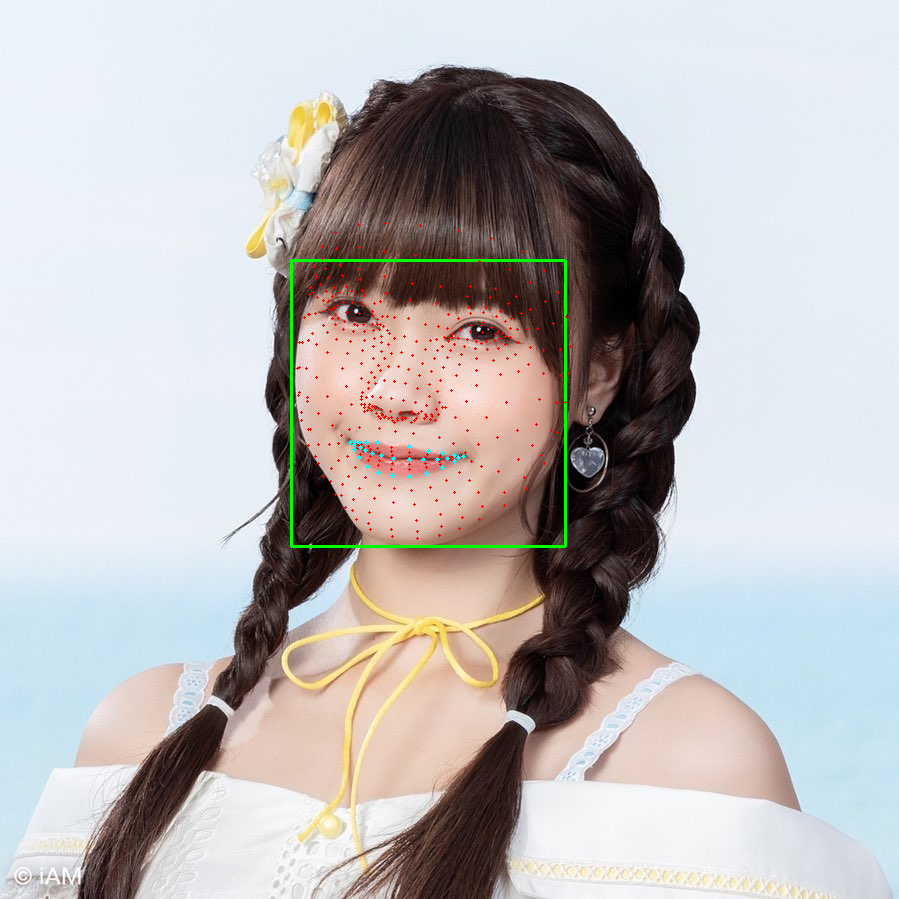

In [37]:
def refine_lip_landmarks(image, results):
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            #เลือกจุด Landmark บริเวณปาก
            upper_lip_points = [
                61, 40, 39, 37, 267, 269, 270, 409, 291,  # Inner Upper Lip
                185, 82, 13, 312, 317, 78, 95, 88, 178  # Outer Upper Lip
            ]

            lower_lip_points = [
                78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308,  # Inner Lower Lip
                146, 91, 181, 84, 17, 314, 405, 321, 375, 291  # Outer Lower Lip
            ]

            #รวมจุดทั้งหมดของริมฝีปาก
            lip_points = upper_lip_points + lower_lip_points

            for point in lip_points:
                x = int(face_landmarks.landmark[point].x * image.shape[1])
                y = int(face_landmarks.landmark[point].y * image.shape[0])
                cv2.circle(image, (x, y), 2, (0, 255, 255), -1)  # วาดจุดสีเหลือง

    return image

#ใช้ผลลัพธ์จากการตรวจจับใบหน้า
image_with_refined_lips = refine_lip_landmarks(image_rgb.copy(), results)

#แสดงผลภาพที่มีจุด Landmark ปาก
cv2_imshow(cv2.cvtColor(image_with_refined_lips, cv2.COLOR_RGB2BGR))

#บันทึกภาพ
#cv2.imwrite("refined_lip_landmarks.jpg", cv2.cvtColor(image_with_refined_lips, cv2.COLOR_RGB2BGR))


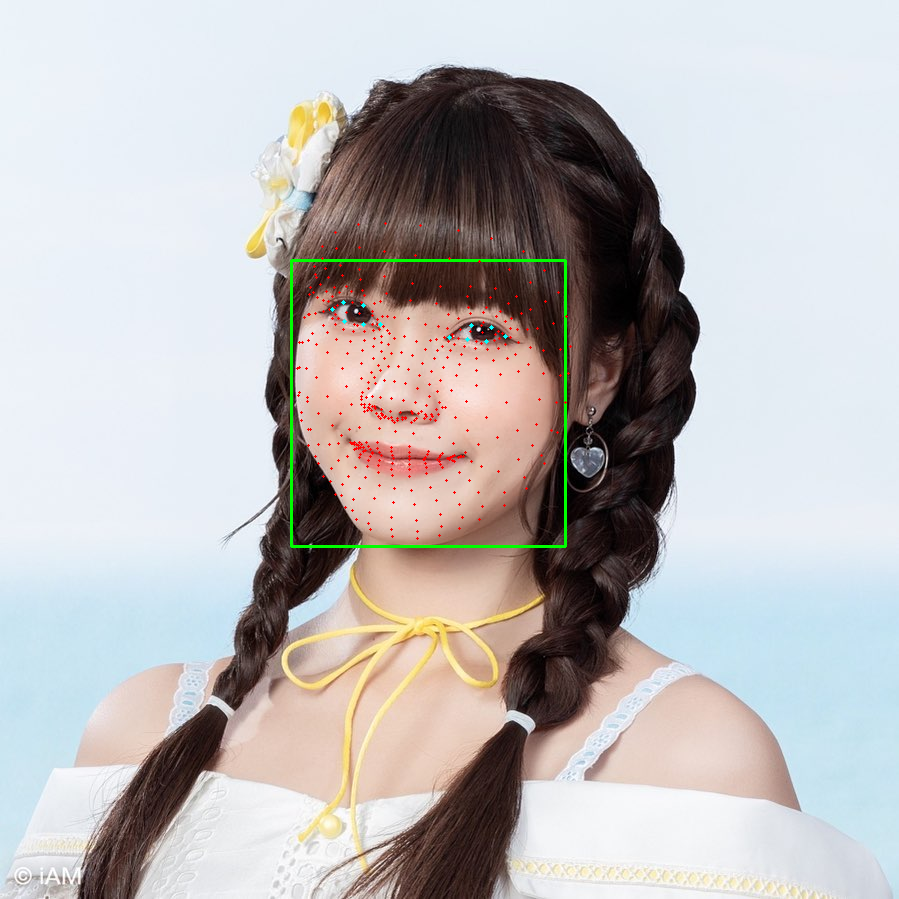

In [38]:
def mark_eye_landmarks(image, results):
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            #Landmark รอบดวงตาข้างซ้าย
            left_eye_points = [
                33, 160, 158, 133, 153, 144, 362, 385, 387, 263, 373, 380
            ]

            #Landmark รอบดวงตาข้างขวา
            right_eye_points = [
                263, 387, 385, 362, 373, 380, 33, 160, 158, 133, 153, 144
            ]

            #รวมทุกจุดของดวงตาทั้งสองข้าง
            eye_points = left_eye_points + right_eye_points

            for point in eye_points:
                x = int(face_landmarks.landmark[point].x * image.shape[1])
                y = int(face_landmarks.landmark[point].y * image.shape[0])
                cv2.circle(image, (x, y), 2, (0, 255, 255), -1)  # วาดจุดสีเหลือง

    return image

#ใช้ผลลัพธ์จากการตรวจจับใบหน้า
image_with_eye_landmarks = mark_eye_landmarks(image_rgb.copy(), results)

#แสดงผลภาพที่มีจุด Landmark ตา
cv2_imshow(cv2.cvtColor(image_with_eye_landmarks, cv2.COLOR_RGB2BGR))

#บันทึกภาพ
#cv2.imwrite("eye_landmarks.jpg", cv2.cvtColor(image_with_eye_landmarks, cv2.COLOR_RGB2BGR))


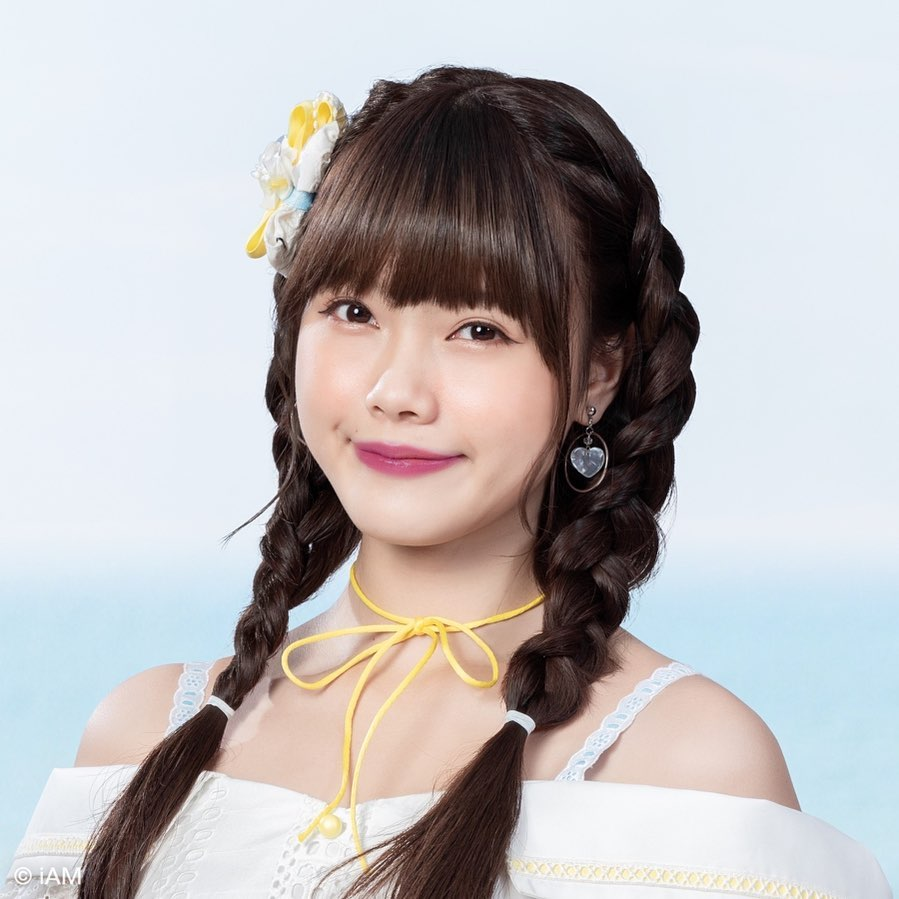

In [39]:
import cv2
import numpy as np

original_image = cv2.imread(IMAGE_PATH)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # แปลงเป็น RGB


def apply_lipstick(image, results, color=(255, 0, 0), opacity=0.4):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)  # สร้าง Mask เปล่า

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            #ใช้จุด Landmark บริเวณปาก
            lip_points = [
                61, 40, 39, 37, 267, 269, 270, 409, 291,  # Inner Upper Lip
                185, 82, 13, 312, 317, 78, 95, 88, 178,  # Outer Upper Lip
                78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308,  # Inner Lower Lip
                146, 91, 181, 84, 17, 314, 405, 321, 375, 291  # Outer Lower Lip
            ]

            points = []
            for point in lip_points:
                x = int(face_landmarks.landmark[point].x * image.shape[1])
                y = int(face_landmarks.landmark[point].y * image.shape[0])
                points.append((x, y))

            #วาด Polygon ของปากเพื่อสร้าง Mask
            cv2.fillPoly(mask, [np.array(points, dtype=np.int32)], 255)

    #Gaussian Blur ให้ขอบของ Mask นุ่มนวลขึ้น
    mask_blur = cv2.GaussianBlur(mask, (11, 11), 5)

    #ใช้ Mask นี้ลงสีเฉพาะบริเวณปาก
    colored_lips = np.zeros_like(image, dtype=np.uint8)
    colored_lips[:, :] = color  # กำหนดสีลิปสติก

    #สีปาก
    alpha = mask_blur / 255.0 * opacity
    blended = (1.0 - alpha[:, :, None]) * image + (alpha[:, :, None]) * colored_lips
    blended = blended.astype(np.uint8)

    return blended

#ลงสีบนภาพต้นฉบับ
image_with_lipstick = apply_lipstick(original_image.copy(), results, color=(128, 0, 128), opacity=0.3)  # ✅ ลด opacity

# แสดงผลภาพ
cv2_imshow(cv2.cvtColor(image_with_lipstick, cv2.COLOR_RGB2BGR))

#บันทึกภาพ
#cv2.imwrite("lipstick_more_transparent.jpg", cv2.cvtColor(image_with_lipstick, cv2.COLOR_RGB2BGR))

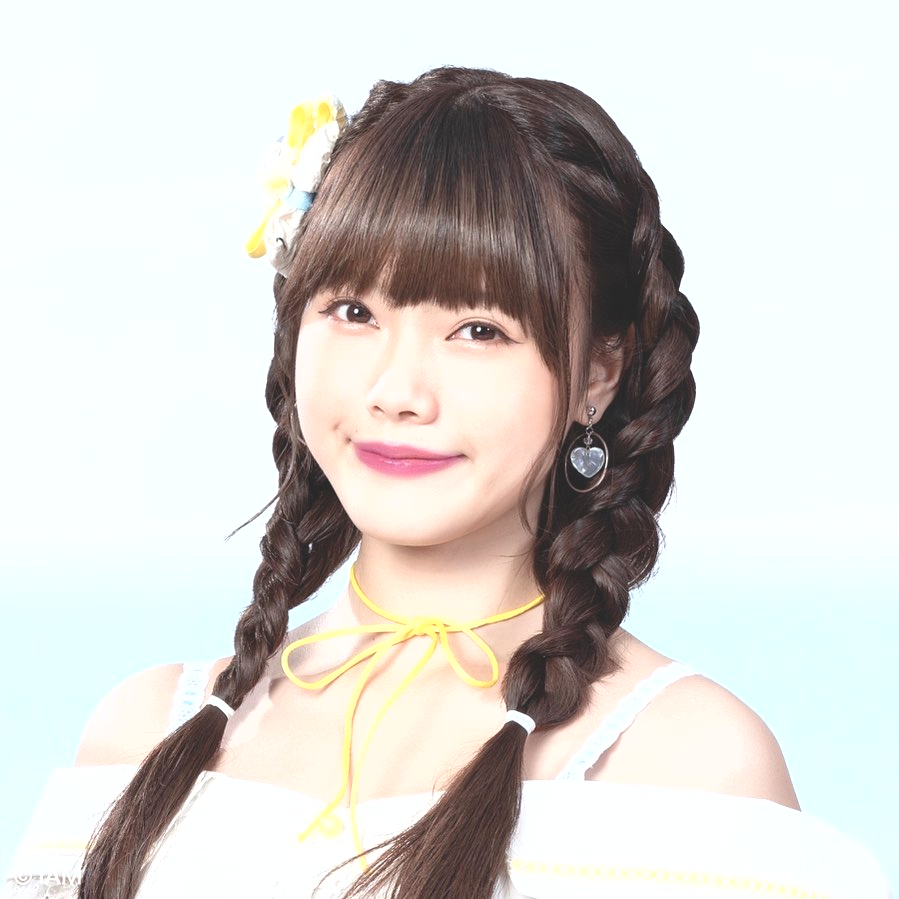

In [40]:
def brighten_skin(image, intensity=30):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)  #แปลงเป็น LAB
    l, a, b = cv2.split(lab)

    #ปรับค่าความสว่างของแชนแนล L เพื่อให้ผิวขาวขึ้น
    l = cv2.add(l, intensity)
    l = np.clip(l, 0, 255)  #จำกัดค่าไม่ให้เกินขอบเขตสี

    lab = cv2.merge((l, a, b))
    brightened = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)  #แปลงกลับเป็น RGB

    return brightened

#ปรับโทนผิวให้ขาวใส
image_with_whitened_skin = brighten_skin(image_with_lipstick.copy(), intensity=40)

#แสดงผลภาพ
cv2_imshow(cv2.cvtColor(image_with_whitened_skin, cv2.COLOR_RGB2BGR))

#บันทึกภาพ
#cv2.imwrite("whitened_skin.jpg", cv2.cvtColor(image_with_whitened_skin, cv2.COLOR_RGB2BGR))

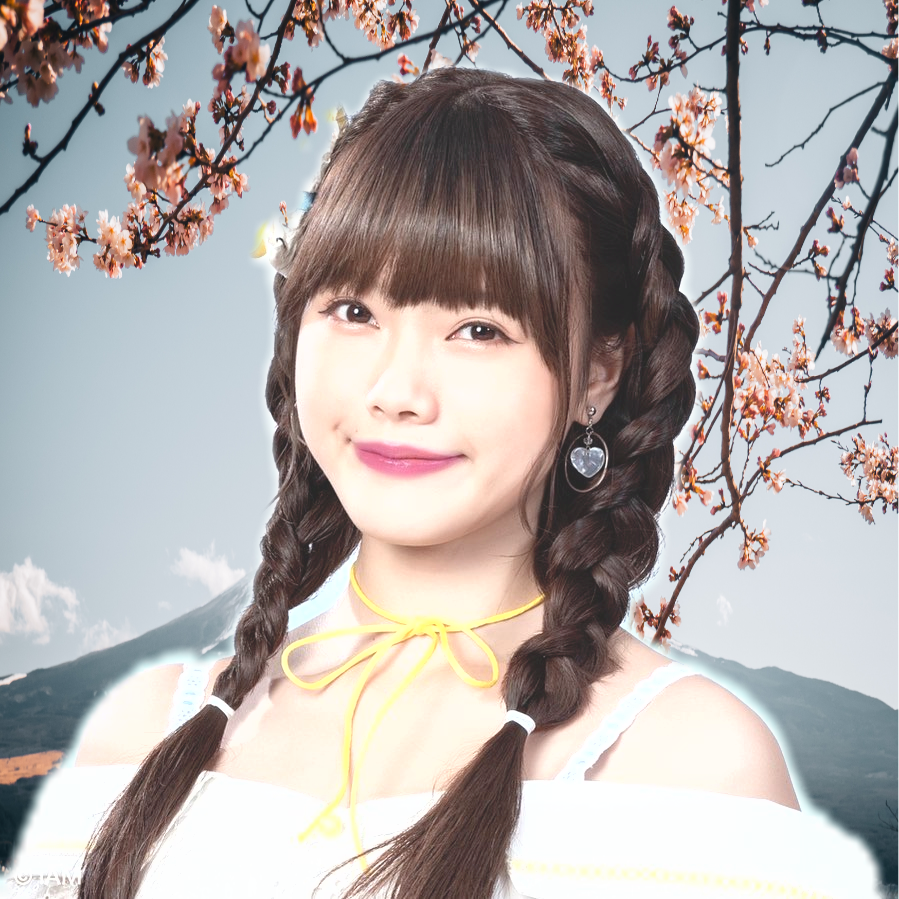

In [42]:
def change_background(image, bg_image_path, threshold=0.1):
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    #โหลดพื้นหลัง
    bg_image = cv2.imread(bg_image_path)
    bg_image = cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGB)

    #ตรวจสอบขนาดของพื้นหลัง
    h, w, _ = image.shape
    bg_image = cv2.resize(bg_image, (w, h))

    #ใช้ MediaPipe Selfie Segmentation
    results = selfie_segmentation.process(image)

    #สร้าง Mask สำหรับแยกบุคคลออกจากพื้นหลัง
    mask = results.segmentation_mask
    mask = (mask > threshold).astype(np.uint8)

    #ทำให้ขอบของ Mask นุ่มนวลขึ้น
    mask_blur = cv2.GaussianBlur(mask.astype(np.float32), (15, 15), 5)

    #รวมภาพระหว่างพื้นหลังใหม่กับบุคคล
    output_image = (mask_blur[:, :, None] * image + (1 - mask_blur[:, :, None]) * bg_image).astype(np.uint8)

    return output_image

#ภาพพื้นหลังที่ต้องการใช้
BACKGROUND_PATH = "/content/drive/MyDrive/AI_photobooth/background/Fuji_background.png"

#เปลี่ยนพื้นหลังของภาพที่แต่งหน้าสำเร็จแล้ว
image_with_new_bg = change_background(image_with_whitened_skin.copy(), BACKGROUND_PATH)

#แสดงผลลัพธ์
cv2_imshow(cv2.cvtColor(image_with_new_bg, cv2.COLOR_RGB2BGR))

#บันทึกภาพที่มีพื้นหลังใหม่
#cv2.imwrite("changed_background.jpg", cv2.cvtColor(image_with_new_bg, cv2.COLOR_RGB2BGR))

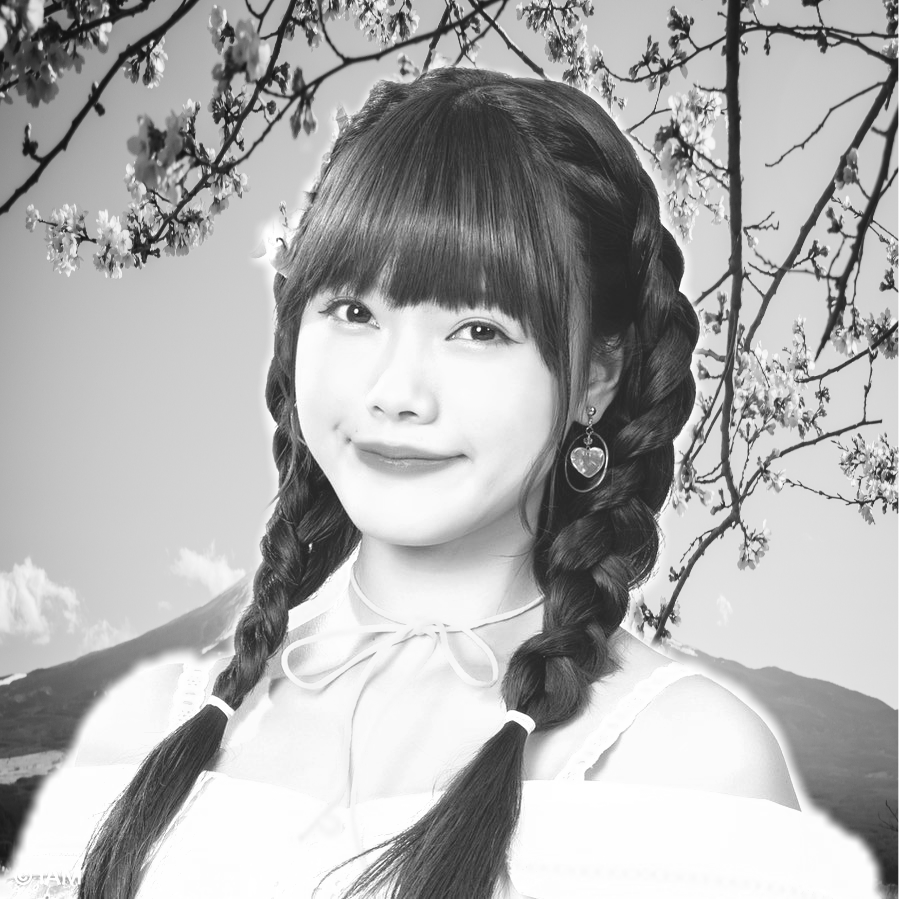

In [43]:
def convert_to_grayscale(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # แปลงเป็น Grayscale
    grayscale = cv2.cvtColor(grayscale, cv2.COLOR_GRAY2RGB)  # แปลงกลับเป็น RGB เพื่อให้แสดงผลได้ถูกต้อง
    return grayscale

#ใช้ฟังก์ชัน convert_to_grayscale กับภาพที่แต่งเสร็จแล้ว
image_grayscale = convert_to_grayscale(image_with_new_bg.copy())

#แสดงผลภาพขาวดำ
cv2_imshow(cv2.cvtColor(image_grayscale, cv2.COLOR_RGB2BGR))

#บันทึกภาพ
#cv2.imwrite("grayscale_image.jpg", cv2.cvtColor(image_grayscale, cv2.COLOR_RGB2BGR))